
===== BASIC INFO =====
Rows: 67831
Columns: 16

===== TIME RANGE =====
shape: (1, 2)
┌────────────┬────────────┐
│ start_time ┆ end_time   │
│ ---        ┆ ---        │
│ i64        ┆ i64        │
╞════════════╪════════════╡
│ 1656288010 ┆ 1656374390 │
└────────────┴────────────┘

Unique aircraft: 1068

===== MISSING VALUES =====
shape: (1, 16)
┌──────┬────────┬─────┬─────┬──────────┬─────────┬──────────┬──────────┬──────────┬───────┬─────┬────────┬──────────────┬─────────────┬───────────────┬─────────────┐
│ time ┆ icao24 ┆ lat ┆ lon ┆ velocity ┆ heading ┆ vertrate ┆ callsign ┆ onground ┆ alert ┆ spi ┆ squawk ┆ baroaltitude ┆ geoaltitude ┆ lastposupdate ┆ lastcontact │
│ ---  ┆ ---    ┆ --- ┆ --- ┆ ---      ┆ ---     ┆ ---      ┆ ---      ┆ ---      ┆ ---   ┆ --- ┆ ---    ┆ ---          ┆ ---         ┆ ---           ┆ ---         │
│ u32  ┆ u32    ┆ u32 ┆ u32 ┆ u32      ┆ u32     ┆ u32      ┆ u32      ┆ u32      ┆ u32   ┆ u32 ┆ u32    ┆ u32          ┆ u32         ┆ u32           ┆ u3

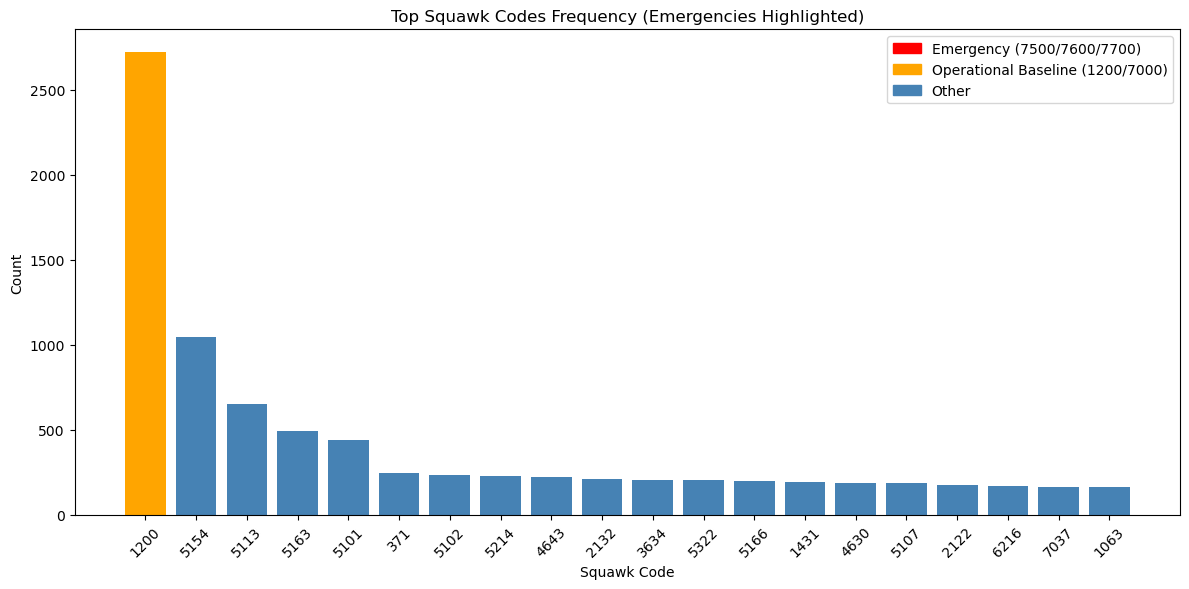

In [16]:
# ============================================
# OpenSky EDA Script (Polars Version)
# ============================================

from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt

pl.Config.set_tbl_cols(-1)          # show all columns
pl.Config.set_tbl_rows(1000)         # number of visible rows
pl.Config.set_tbl_width_chars(200)  # wider table

BASE_DIR = Path.cwd()

data_dir = BASE_DIR / ".." / ".." / ".." / "data_pipeline" / "raw_data"
# extract_dir = BASE_DIR / "raw_data" / "extracted"

# INPUT_FILE = "bwi_states_smoothed_resampled.csv"

INPUT_FILE = "/home/jon/Documents/grad_school/OR568/project/OR568_ML_Project/data_pipeline/raw_data/bwi_states_2022_06_27_raw.csv"

# --------------------------------------------
# LOAD DATA
# --------------------------------------------
df = pl.read_csv(INPUT_FILE, try_parse_dates=True)

print("\n===== BASIC INFO =====")
print("Rows:", df.height)
print("Columns:", len(df.columns))

# --------------------------------------------
# TIME RANGE
# --------------------------------------------
print("\n===== TIME RANGE =====")
print(df.select([
    pl.col("time").min().alias("start_time"),
    pl.col("time").max().alias("end_time")
]))

# --------------------------------------------
# UNIQUE AIRCRAFT
# --------------------------------------------
print("\nUnique aircraft:", df.select(pl.col("icao24").n_unique()).item())

# --------------------------------------------
# NULL COUNTS
# --------------------------------------------
print("\n===== MISSING VALUES =====")
nulls = df.select([
    pl.all().null_count()
])
print(nulls)

# ============================================
# SQUAWK FREQUENCY DISTRIBUTION
# ============================================

print("\n===== SQUAWK FREQUENCY =====")

# -----------------------------------
# Frequency table
# -----------------------------------
squawk_freq = (
    df.filter(pl.col("squawk").is_not_null())
      .group_by("squawk")
      .len()
      .sort("len", descending=True)
)

print(squawk_freq.head(20))

top_sq = squawk_freq.head(20)

# -----------------------------------
# Highlight logic
# -----------------------------------

EMERGENCY_CODES = {"7500", "7600", "7700"}
IMPORTANT_CODES = {"1200", "7000"}

colors = []

for sq in top_sq["squawk"].cast(str):
    if sq in EMERGENCY_CODES:
        colors.append("red")          # emergencies
    elif sq in IMPORTANT_CODES:
        colors.append("orange")       # operational baseline
    else:
        colors.append("steelblue")    # normal

# -----------------------------------
# Plot
# -----------------------------------

plt.figure(figsize=(12,6))

plt.bar(
    top_sq["squawk"].cast(str),
    top_sq["len"],
    color=colors
)

plt.title("Top Squawk Codes Frequency (Emergencies Highlighted)")
plt.xlabel("Squawk Code")
plt.ylabel("Count")

plt.xticks(rotation=45)

# legend
import matplotlib.patches as mpatches

legend_handles = [
    mpatches.Patch(color="red", label="Emergency (7500/7600/7700)"),
    mpatches.Patch(color="orange", label="Operational Baseline (1200/7000)"),
    mpatches.Patch(color="steelblue", label="Other")
]

plt.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

# # ============================================
# # MOVEMENT STATISTICS
# # ============================================

# print("\n===== NUMERIC SUMMARY =====")

# numeric_cols = [
#     "velocity",
#     "geoaltitude",
#     "baroaltitude",
#     "vertrate",
#     "heading"
# ]

# summary = df.select([
#     pl.col(c).mean().alias(f"{c}_mean") for c in numeric_cols
# ] + [
#     pl.col(c).std().alias(f"{c}_std") for c in numeric_cols
# ] + [
#     pl.col(c).min().alias(f"{c}_min") for c in numeric_cols
# ] + [
#     pl.col(c).max().alias(f"{c}_max") for c in numeric_cols
# ])

# print(summary)

# # ============================================
# # OPERATIONAL FLAGS
# # ============================================

# print("\n===== OPERATIONAL FLAGS =====")

# flags = df.select([
#     (pl.col("onground") == True).mean().alias("pct_onground"),
#     (pl.col("alert") == True).mean().alias("pct_alert"),
#     (pl.col("spi") == True).mean().alias("pct_spi")
# ])

# print(flags)

# # ============================================
# # PER AIRCRAFT SUMMARY (ML READY)
# # ============================================

# print("\n===== AIRCRAFT LEVEL SUMMARY =====")

# aircraft_summary = (
#     df.group_by("icao24")
#       .agg([
#           pl.col("velocity").mean().alias("avg_velocity"),
#           pl.col("geoaltitude").max().alias("max_altitude"),
#           pl.col("time").min().alias("start_time"),
#           pl.col("time").max().alias("end_time"),
#           pl.len().alias("samples")
#       ])
# )

# print(aircraft_summary.head())

# # Optional save for ML
# aircraft_summary.write_csv("aircraft_summary.csv")

# print("\nSaved aircraft summary → aircraft_summary.csv")

In [17]:
EMERGENCY_CODES = {"7500", "7600", "7700"}

emergency_df = (
    df.filter(
        pl.col("squawk")
          .cast(pl.Utf8)
          .is_in(EMERGENCY_CODES)
    )
)

print(emergency_df)

shape: (25, 16)
┌────────────┬────────┬───────────┬────────────┬────────────┬────────────┬───────────┬──────────┬──────────┬───────┬───────┬────────┬──────────────┬─────────────┬───────────────┬─────────────┐
│ time       ┆ icao24 ┆ lat       ┆ lon        ┆ velocity   ┆ heading    ┆ vertrate  ┆ callsign ┆ onground ┆ alert ┆ spi   ┆ squawk ┆ baroaltitude ┆ geoaltitude ┆ lastposupdate ┆ lastcontact │
│ ---        ┆ ---    ┆ ---       ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---      ┆ ---      ┆ ---   ┆ ---   ┆ ---    ┆ ---          ┆ ---         ┆ ---           ┆ ---         │
│ i64        ┆ str    ┆ f64       ┆ f64        ┆ f64        ┆ f64        ┆ f64       ┆ str      ┆ bool     ┆ bool  ┆ bool  ┆ i64    ┆ f64          ┆ f64         ┆ f64           ┆ f64         │
╞════════════╪════════╪═══════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪══════════╪═══════╪═══════╪════════╪══════════════╪═════════════╪═══════════════╪═════════════╡
│ 1656297100 ┆ a97d

/tmp/ipykernel_56177/402016319.py:24: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


shape: (2, 2)
┌────────┬───────┐
│ squawk ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ 7500   ┆ 17    │
│ 7700   ┆ 8     │
└────────┴───────┘


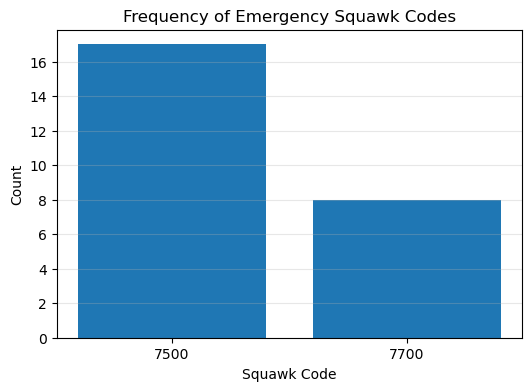

In [18]:
# ----------------------------------------
# 1. Define emergency squawk codes
# ----------------------------------------
EMERGENCY_CODES = {"7500", "7600", "7700"}

# ----------------------------------------
# 2. Filter emergency rows
# ----------------------------------------
emergency_df = (
    df.filter(
        pl.col("squawk")
          .cast(pl.Utf8)
          .is_in(EMERGENCY_CODES)
    )
)

# ----------------------------------------
# 3. Frequency count per code
# ----------------------------------------
freq_df = (
    emergency_df
    .with_columns(pl.col("squawk").cast(pl.Utf8))
    .group_by("squawk")
    .count()
    .sort("count", descending=True)
)

print(freq_df)

# ----------------------------------------
# 4. Plot frequency graph
# ----------------------------------------
plot_df = freq_df.to_pandas()

plt.figure(figsize=(6,4))
plt.bar(plot_df["squawk"], plot_df["count"])
plt.title("Frequency of Emergency Squawk Codes")
plt.xlabel("Squawk Code")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)

plt.show()